In [1]:
!pip install torchvision

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim 
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark=True
plt.ion()

IOStream.flush timed out
Matplotlib is building the font cache; this may take a moment.


In [3]:
data_dir='./hymenoptera_data'
print(data_dir)

./hymenoptera_data


In [4]:
data_transforms={
'train':transforms.Compose([
transforms.RandomResizedCrop(224),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
]),
'val':transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
]),
    
}

In [5]:
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                   for x in ['train','val']}
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4)
            for x in ['train','val']}
dataset_size={x:len(image_datasets[x]) for x in  ['train','val']}
class_names=image_datasets['train'].classes

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                    
                    

In [6]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: ./hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: ./hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

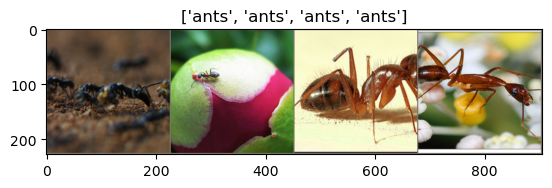

In [7]:
def show(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs,classes=next(iter(dataloaders['train']))

out=torchvision.utils.make_grid(inputs)

show(out,title=[class_names[x] for x in classes])

In [8]:
def train_model(model,criterion,optimizer,scheduler,num_epoches=20):
    since=time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path=os.path.join(tempdir,'best_model_params.pt')
        
        torch.save(model.state_dict(),best_model_params_path)
        best_acc=0.0
        
        for epoch in range(num_epoches):
            print(f"Epoch{epoch}/{num_epoches-1}")
            print('-'*10)
            
            for phase in ['train','val']:
                if phase=='train':
                    model.train()
                else:
                    model.eval()
            running_loss=0.0
            running_corrects=0
            
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=="train"):
                    outputs=model(inputs)
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    
                    if phase =="train":
                        loss.backward()
                        optimizer.step()
                running_loss +=loss.item()*inputs.size(0)
                running_corrects +=torch.sum(preds==labels.data)
            if phase=='train':
                scheduler.step()
            epoch_loss=running_loss/dataset_size[phase]
            epoch_acc=running_corrects.double()/dataset_size[phase]
            
            print(f"{phase} loss:{epoch_loss:.4f} Acc:{epoch_acc:.4f}")
            if phase =="val" and epoch_acc>best_acc:
                best_acc=epoch_acc
                torch.save(model.state_dict(),best_model_params_path)
       
        time_elapsed=time.time()-since
       
        print(f"Best val acc:{best_acc:.4f}")
    
        model.load_state_dict(torch.load(best_model_params_path,weights_only=True))
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title("predicted:", class_names[preds[j]])
                show(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)                                                  

In [13]:
model_ft=models.resnet18(weights="IMAGENET1K_V1")
num_ftrs=model_ft.fc.in_features

model_ft.tc=nn.Linear(num_ftrs,2)
model_ft=model_ft.to(device)
criterion=nn.CrossEntropyLoss()
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


In [14]:
num_epoches=7

In [15]:
model_fit = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epoches)

Epoch0/6
----------
val loss:15.7995 Acc:0.0000
Epoch1/6
----------
val loss:15.7995 Acc:0.0000
Epoch2/6
----------
val loss:15.7995 Acc:0.0000
Epoch3/6
----------
val loss:15.7995 Acc:0.0000
Epoch4/6
----------
val loss:15.7995 Acc:0.0000
Epoch5/6
----------
val loss:15.7995 Acc:0.0000
Epoch6/6
----------
val loss:15.7995 Acc:0.0000
Best val acc:0.0000


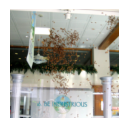

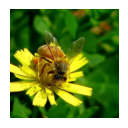

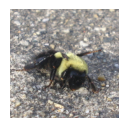

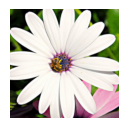

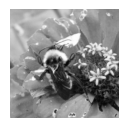

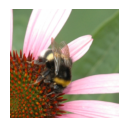

In [20]:
visualize_model(model_fit)
plt.ioff()
plt.show()

##ConvNet as fixed feature extractor

In [21]:
model_conv=torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad=False
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)
model_conv=model_conv.to(device)

crriterion=nn.CrossEntropyLoss()

optimizer_conv=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler=lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)


In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epoches=25)

Epoch0/24
----------
val loss:0.7404 Acc:0.5621
Epoch1/24
----------
val loss:0.7404 Acc:0.5621
Epoch2/24
----------
val loss:0.7404 Acc:0.5621
Epoch3/24
----------
val loss:0.7404 Acc:0.5621
Epoch4/24
----------
val loss:0.7404 Acc:0.5621
Epoch5/24
----------
val loss:0.7404 Acc:0.5621
Epoch6/24
----------
val loss:0.7404 Acc:0.5621
Epoch7/24
----------
val loss:0.7404 Acc:0.5621
Epoch8/24
----------
val loss:0.7404 Acc:0.5621
Epoch9/24
----------
val loss:0.7404 Acc:0.5621
Epoch10/24
----------
val loss:0.7404 Acc:0.5621
Epoch11/24
----------
val loss:0.7404 Acc:0.5621
Epoch12/24
----------
val loss:0.7404 Acc:0.5621
Epoch13/24
----------
val loss:0.7404 Acc:0.5621
Epoch14/24
----------
val loss:0.7404 Acc:0.5621
Epoch15/24
----------
val loss:0.7404 Acc:0.5621
Epoch16/24
----------
val loss:0.7404 Acc:0.5621
Epoch17/24
----------
val loss:0.7404 Acc:0.5621
Epoch18/24
----------
val loss:0.7404 Acc:0.5621
Epoch19/24
----------
val loss:0.7404 Acc:0.5621
Epoch20/24
----------
val loss

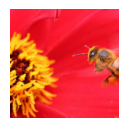

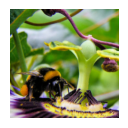

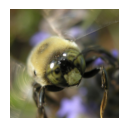

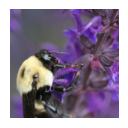

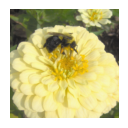

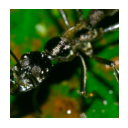

In [25]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [28]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()
    img=Image.open(img_path)
    img=data_transforms['val'](img)
    img=img.unsqueez(0)
    img=img.to(device)
    

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        ax=plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'predicted:{class_names[preds[0]]}')
        imshow(img.cpu().data[0])

            
        model.train(mode=was_training)   

In [31]:
os.getcwd()

'/home/ec2-user/SageMaker'

In [32]:
visualize_model_predictions(
    model_conv,
    img_path='./home/ec2-user/SageMaker/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/SageMaker/home/ec2-user/SageMaker/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'